In [2]:
# Import required libraries
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, precision_score, recall_score

In [3]:
# Define the LSTM Autoencoder class inline (previously imported from models)
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, input_dim, batch_first=True)

    def forward(self, x):
        _, (hidden, _) = self.encoder(x)
        hidden_repeated = hidden.repeat(x.size(1), 1, 1).permute(1, 0, 2)
        out, _ = self.decoder(hidden_repeated)
        return out

In [4]:
# Load preprocessed data
df = pd.read_csv('data/cryogenic_synthetic_preprocessed.csv', parse_dates=['Timestamp'])

In [5]:
# Parameters
sequence_length = 30
input_dim = 1

# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return np.stack(sequences)

temp_data = df['Temperature (°C)'].values.reshape(-1, 1)
sequences = create_sequences(temp_data, sequence_length)

In [6]:
# Convert to PyTorch tensors
X_test = torch.tensor(sequences, dtype=torch.float32)

In [7]:
model = LSTMAutoencoder(input_dim=input_dim, hidden_dim=64)  # used the same hidden_dim we used during training
model.load_state_dict(torch.load('outputs/frostnet_lstm_autoencoder.pth'))
model.eval()

LSTMAutoencoder(
  (encoder): LSTM(1, 64, batch_first=True)
  (decoder): LSTM(64, 1, batch_first=True)
)

In [8]:
# Inference
with torch.no_grad():
    reconstructed = model(X_test)
    loss_fn = nn.MSELoss(reduction='none')
    losses = loss_fn(reconstructed, X_test).mean(dim=(1, 2))

In [9]:
# Define threshold
threshold = np.percentile(losses.numpy(), 95)
anomalies = (losses > threshold).int().numpy()

In [10]:
# Align prediction output with original dataframe
padding = [0] * sequence_length
full_anomaly_flags = np.concatenate([padding, anomalies])
df['Reconstructed_Loss'] = np.concatenate([padding, losses.numpy()])
df['Predicted_Anomaly'] = full_anomaly_flags

In [11]:
# Evaluation Metrics
y_true = df['Anomaly'].values
precision = precision_score(y_true, full_anomaly_flags)
recall = recall_score(y_true, full_anomaly_flags)
mae = mean_absolute_error(y_true, full_anomaly_flags)
rmse = root_mean_squared_error(y_true, full_anomaly_flags)

In [12]:
print("Model Evaluation Metrics")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

Model Evaluation Metrics
Precision: 0.0120
Recall: 0.0600
MAE: 0.0587
RMSE: 0.2423


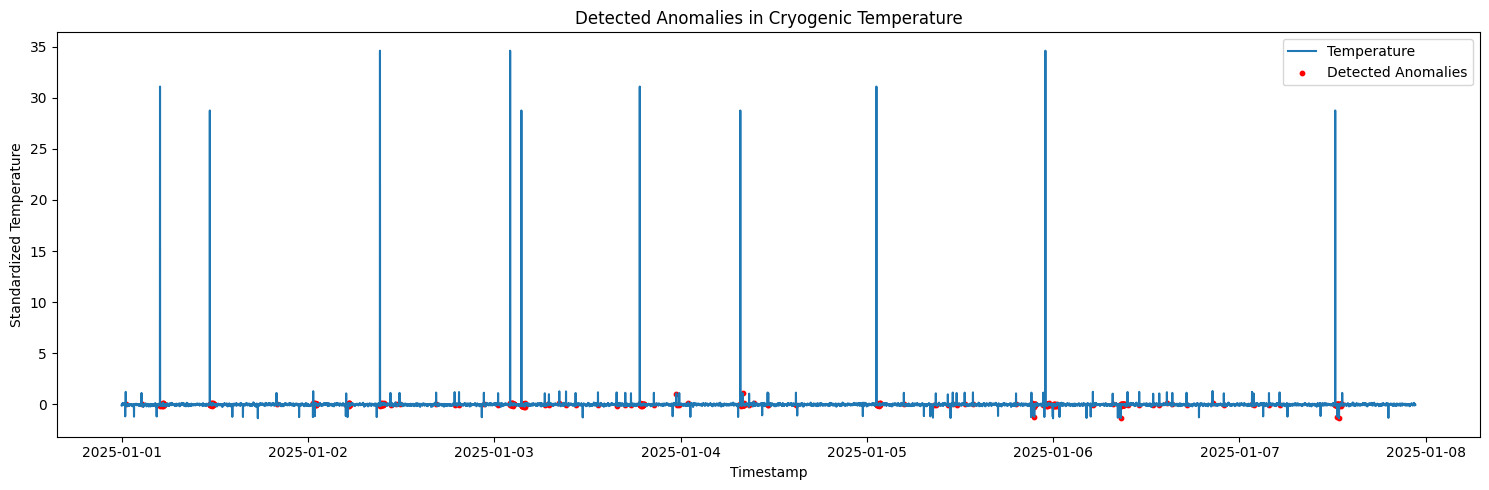

✅ Anomaly detection and evaluation completed.


In [13]:
# Plot anomalies
plt.figure(figsize=(15,5))
anomaly_indices = df[df['Predicted_Anomaly'] == 1].index
plt.plot(df['Timestamp'], df['Temperature (°C)'], label='Temperature')
plt.scatter(df.loc[anomaly_indices, 'Timestamp'], df.loc[anomaly_indices, 'Temperature (°C)'], color='red', label='Detected Anomalies', s=10)
plt.legend()
plt.title('Detected Anomalies in Cryogenic Temperature')
plt.xlabel('Timestamp')
plt.ylabel('Standardized Temperature')
plt.tight_layout()
plt.show()

print("✅ Anomaly detection and evaluation completed.")

In [14]:
# Save results to CSV
results_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'MAE', 'RMSE'],
    'Value': [precision, recall, mae, rmse]
})
results_df.to_csv('outputs/evaluation_results.csv', index=False)